In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from models.densenet import DenseNet3
import util.svhn_loader as svhn

In [2]:
transform_cifar = transforms.Compose([
  transforms.Resize(32),
  transforms.CenterCrop(32),
  transforms.ToTensor(),
  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

datasets = {
  'CIFAR-10': torchvision.datasets.CIFAR10(root='./datasets/id_datasets/', train=False, download=True, transform=transform_cifar),
  'CIFAR-100': torchvision.datasets.CIFAR100(root='./datasets/id_datasets/', train=False, download=True, transform=transform_cifar), 
  'SVHN': svhn.SVHN('datasets/ood_datasets/svhn/', split='test', transform=transform_cifar, download=False),
  'dtd': torchvision.datasets.ImageFolder(root="datasets/ood_datasets/dtd/images", transform=transform_cifar),
  'places365': torchvision.datasets.ImageFolder(root="datasets/ood_datasets/places365/", transform=transform_cifar),
  'celebA': torchvision.datasets.CelebA(root='datasets/ood_datasets/', split='test', download=True, transform=transform_cifar),
  'iSUN': torchvision.datasets.ImageFolder("./datasets/ood_datasets/iSUN", transform=transform_cifar),
  'LSUN': torchvision.datasets.ImageFolder("./datasets/ood_datasets/LSUN", transform=transform_cifar),
  'LSUN_resize': torchvision.datasets.ImageFolder("./datasets/ood_datasets/LSUN_resize", transform=transform_cifar),
}

dataloaders = {
  k: torch.utils.data.DataLoader(v, batch_size=128, shuffle=False) for k,v in datasets.items()
}

ood_dls = ['SVHN', 'LSUN', 'LSUN_resize', 'iSUN', 'dtd', 'places365']

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
import sys
sys.path.append('./code/')

from stats import Stats, Recorder

device = 'cuda:1'

In [5]:
model = DenseNet3(100, 100, 12, reduction=0.5, bottleneck=True, dropRate=0.0, normalizer=None, p=None, info=None)
checkpoint = torch.load("./checkpoints/CIFAR-100/densenet/checkpoint_100.pth.tar", map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.eval();

In [6]:
# _, eval_nodes = get_graph_node_names(model)
# print(eval_nodes)

In [7]:
return_nodes = {
  'x': 'input',
  'conv1': 'conv',
  'trans1.avg_pool2d': 'block1',
  'trans2.avg_pool2d': 'block2',
  'avg_pool2d': 'block3',
  # 'block1.layer.15.cat': 'block1',
  # 'block2.layer.15.cat': 'block2',
  # 'block3.layer.15.cat': 'block3',
  'view': 'feature',
  'fc': 'logit',
}

# s = Stats(model, return_nodes, device)
# s.run(dataloaders['CIFAR-10'])

In [8]:
extractor = create_feature_extractor(model, return_nodes).to(device)

In [9]:
id_recorder = Recorder(state_names=list(return_nodes.values()), compute_on_cpu=True)
id_target = Recorder(state_names=['target'])

for x,y in tqdm(dataloaders['CIFAR-100']):
  with torch.no_grad():
    x = x.to(device)
    features = extractor(x)
    id_recorder.update(features)
    id_target.update({'target': y})

  0%|          | 0/79 [00:00<?, ?it/s]

In [10]:
svhn_recorder = Recorder(state_names=list(return_nodes.values()), compute_on_cpu=True)
svhn_target = Recorder(state_names=['target'])

for x,y in tqdm(dataloaders['SVHN']):
  with torch.no_grad():
    x = x.to(device)
    features = extractor(x)
    svhn_recorder.update(features)
    svhn_target.update({'target': y})

  0%|          | 0/79 [00:00<?, ?it/s]

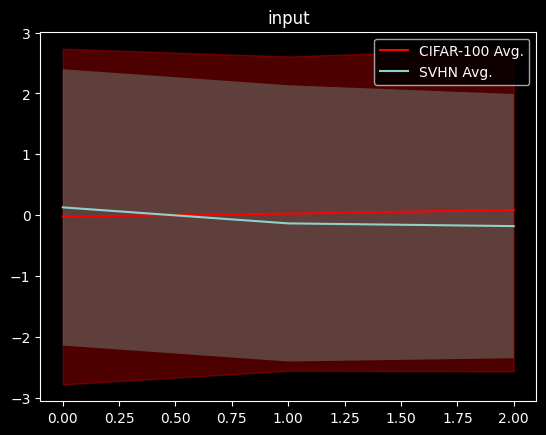

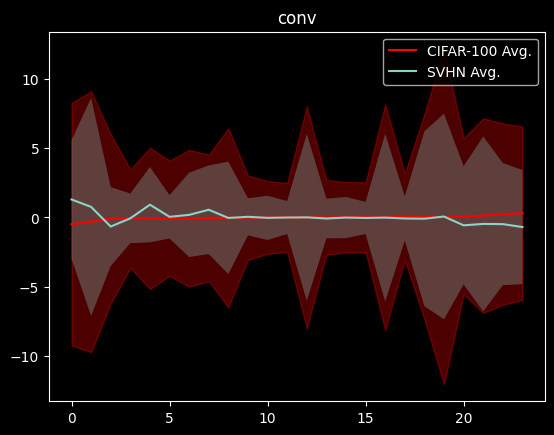

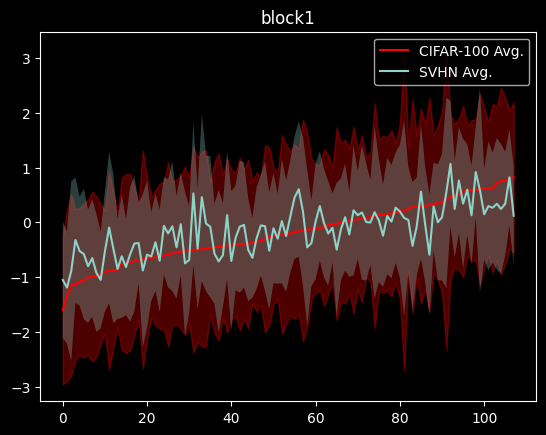

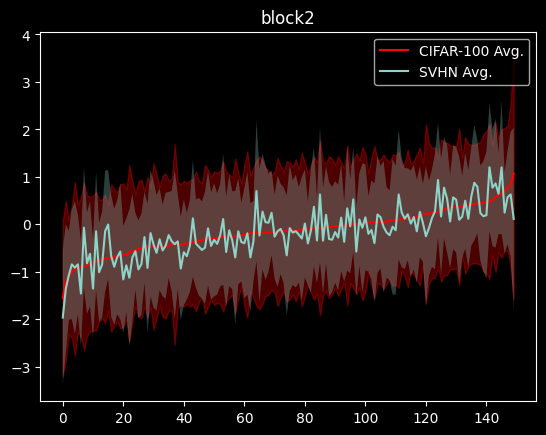

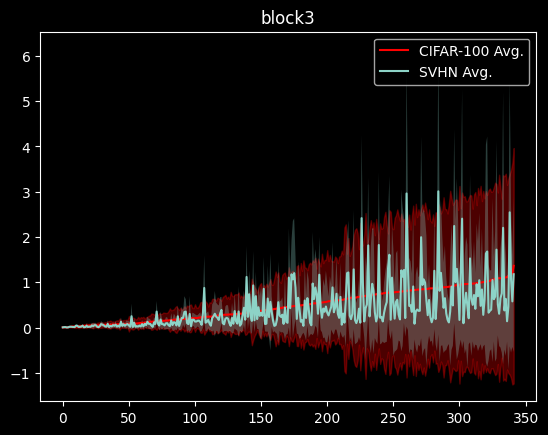

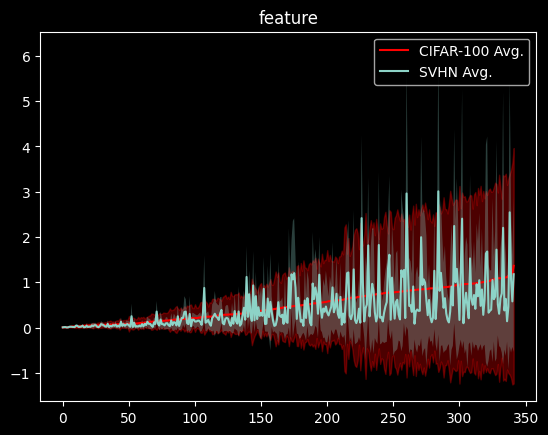

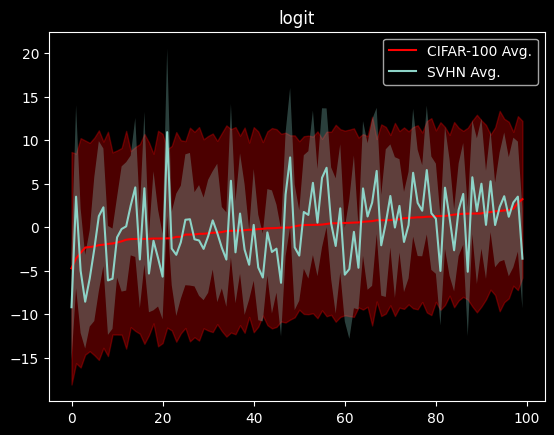

In [15]:
tgt = id_target._final_state()['target']

avg, std = id_recorder.stats(std=True)
idx = {k: v.argsort() for k,v in avg.items()}
# avg_cls = [id_recorder.stats(tgt == i) for i in range(100)]

svhn_avg, svhn_std = svhn_recorder.stats(std=True)

for k in return_nodes.values():  
  plt.title(k)
  plt.plot(range(len(idx[k])), avg[k][idx[k]], color='red', label='CIFAR-100 Avg.')
  plt.fill_between(range(len(idx[k])), (avg[k] - 2*std[k])[idx[k]], (avg[k] + 2*std[k])[idx[k]], color='red', alpha=.3)

  plt.plot(range(len(idx[k])), svhn_avg[k][idx[k]], label='SVHN Avg.')
  plt.fill_between(range(len(idx[k])), (svhn_avg[k] - 2*svhn_std[k])[idx[k]], (svhn_avg[k] + 2*svhn_std[k])[idx[k]], alpha=.3)
  # for i in range(100):
    # plt.scatter(range(len(idx[k])), avg_cls[i][k][idx[k]], s=1, label=f'cls_{i}')
  plt.legend()
  plt.show()